In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import optuna
import seaborn as sns
import pandas as pd

# Pytorch for training VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Metrics to measure
import sklearn
from sklearn.model_selection import KFold

import time
import random
import os                          # Import operating system interface
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Set deterministic environment

In [ ]:
seed = 42
random.seed(seed) # random seed for Python's random module
np.random.seed(seed) # random seed for NumPy
torch.manual_seed(seed) # random seed for PyTorch

First , we generate some feasible designs and combinations for each solvent with the following code:

In [ ]:
def data_encoder_generation(bounds, num_initial_points, categorical_variables = 4,seed = 42):
    """
    :parambounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks if a point satisfies the constraints.
    :return: Results
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points = []
    total_points = num_initial_points* categorical_variables
    while len(initial_points) < total_points:
        candidate_point = []
        for i in range(bounds.shape[1]): 
            value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)      
  
        if satisfies_constraints_discrete(candidate_point):
            for k in range(categorical_variables):
                categorical_val = [k]
                discreteset_val = candidate_point
                initial_points.append( categorical_val + discreteset_val)
    return torch.tensor(initial_points, dtype=torch.float64)


def satisfies_constraints_discrete(x):
    Constraint_List = []
    Constraint_List.append(x[0]<x[1]) 
    Feasibility = all(Constraint_List) == True 
    return Feasibility

bounds = torch.tensor([[1 , 20] ,
                       [60, 60]],dtype = torch.float64)
num_initial_points = 5000
initial_points = data_encoder_generation(bounds , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points))
initial_points

Number of points generated: 20000


tensor([[ 0., 17., 28.],
        [ 1., 17., 28.],
        [ 2., 17., 28.],
        ...,
        [ 1.,  8., 55.],
        [ 2.,  8., 55.],
        [ 3.,  8., 55.]], dtype=torch.float64)

Convert all variables to indices by subtracting the lower bound of each x.

In [4]:
columns_to_encode = initial_points
X_discrete_raw = columns_to_encode.clone()  # tamaño (N, 3)
# X_discrete_idx = X_discrete_raw.clone().detach()
# X_discrete_idx[:, 0] -= 1  # feed1: 1–60 to 0–59
# X_discrete_idx[:, 1] -= 1  # feed: 1–60 to 0–59
# X_discrete_idx[:, 2] -= 20 # column trays: 20-60 to  0-40

Variational AutoEncoder class

In [5]:
class DiscreteAutoencoder(nn.Module):
    def __init__(self, emb_dim=8, latent_dim=8):
        super().__init__()
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim

        # Embeddings para cada variable discreta
        self.var1_emb = nn.Embedding(4, emb_dim)   # 4 solventes
        self.var2_emb = nn.Embedding(60, emb_dim)  # alimentación (1-60)
        self.var3_emb = nn.Embedding(41, emb_dim)  # etapas (20-60)

        # Encoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(3 * emb_dim, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 3 * emb_dim)
        )

        # Individual decoders per variable
        self.var1_out = nn.Linear(emb_dim, 4)
        self.var2_out = nn.Linear(emb_dim, 60)
        self.var3_out = nn.Linear(emb_dim, 41)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # x: batch x 3
        solvent_type, f, nstages = x[:, 0], x[:, 1], x[:, 2]

        # Ajustar índices a 0-based
        solvent_idx = solvent_type
        f1_idx = f - 1
        stage_idx = nstages - 20

        # Embeddings
        solvent_emb = self.var1_emb(solvent_idx)
        f_emb = self.var2_emb(f1_idx)
        st_emb = self.var3_emb(stage_idx)

        # Encoder
        h = torch.cat([solvent_emb, f_emb, st_emb], dim=1)
        h_enc = self.encoder_fc(h)

        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)
        z = self.reparameterize(mu, logvar)

        # Decoder
        h_dec = self.decoder(z)
        f1_dec, f2_dec, st_dec = torch.chunk(h_dec, 3, dim=1)

        # Logits
        f1_logits = self.var1_out(f1_dec)
        f2_logits = self.var2_out(f2_dec)
        st_logits = self.var3_out(st_dec)

        return f1_logits, f2_logits, st_logits, mu, logvar

    def recover(self, z_input):
        z_input = torch.tensor([z_input], dtype=torch.float32)
        y_decoded = self.decoder(z_input).squeeze(0)
        f1_dec, f2_dec, st_dec = torch.chunk(y_decoded, 3, dim=0)

        f1_logits = self.var1_out(f1_dec.unsqueeze(0))
        f2_logits = self.var2_out(f2_dec.unsqueeze(0))
        st_logits = self.var3_out(st_dec.unsqueeze(0))

        # Softmax
        f1_probs = F.softmax(f1_logits, dim=1)
        f2_probs = F.softmax(f2_logits, dim=1)
        st_probs = F.softmax(st_logits, dim=1)

        # Adjust  indexes
        f1_discrete = torch.argmax(f1_probs, dim=1)  # solvente
        f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # alimentación
        # Máask for st_probs
        mask = torch.arange(41, device=st_probs.device).unsqueeze(0)
        invalid_mask = mask <= (f2_discrete.unsqueeze(1) - 20)
        st_probs[invalid_mask] = 0.0
        st_probs = st_probs / st_probs.sum(dim=1, keepdim=True)
        st_discrete = torch.argmax(st_probs, dim=1) + 20  # etapas

        return f1_discrete.item(), f2_discrete.item(), st_discrete.item()


In [6]:
class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def loss_fn(f1_logits, f2_logits, st_logits,   mu, logvar, klratio, targets):
    f1_target, f2_target, st_target = targets[:, 0] , targets[:, 1] - 1, targets[:, 2] - 20
    
    
    # Create copy of st_logits to apply mask
    st_logits_masked = st_logits.clone()
    
    # Dynamic mask: Invalidate categories in x3 that do not satisfy x3 > x2
    for i in range(targets.size(0)):
        invalid_mask = torch.arange(41, device=st_logits.device) <= (f2_target[i] - 20)
        st_logits_masked[i, invalid_mask] = float('-inf')

    f1_loss = F.cross_entropy(f1_logits, f1_target) 
    f2_loss = F.cross_entropy(f2_logits, f2_target)
    st_loss = F.cross_entropy(st_logits_masked, st_target)

    recon_loss = f1_loss + f2_loss + st_loss
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / targets.size(0)

    return recon_loss + klratio*kl_div  # 

In [8]:
def train(model, device, dataloader, optimizer, loss_fn, klratio):
    """
    Trains the model.
    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for X in dataloader:
        # Model prediction and loss calculation
        f1_logits, f2_logits, st_logits, mu, logvar, = model(X[0])
        loss = loss_fn(f1_logits, f2_logits, st_logits, mu, logvar, klratio ,  X[0])
        loss_accum.update(loss.item(), f1_logits.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn, klratio ):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for X in dataloader:
            # Model prediction and loss calculation
            f1_logits, f2_logits, st_logits, mu, logvar= model(X[0])
            loss = loss_fn(f1_logits, f2_logits, st_logits, mu, logvar, klratio, X[0])
            loss_accum.update(loss.item(), f1_logits.size(0))

    return loss_accum.avg

def validation(model, device, dataloader, loss_fn, klratio):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for X in dataloader:
            # Model prediction and loss calculation
            f1_logits, f2_logits, st_logits, mu, logvar= model(X[0])
            loss = loss_fn(f1_logits, f2_logits, st_logits, mu, logvar, klratio,  X[0])
            loss_accum.update(loss.item(), f1_logits.size(0))

    return loss_accum.avg
     

Split data

In [11]:
trainsize = int(len(initial_points)*.70)
train_data_set = TensorDataset(X_discrete_raw.long()[0:trainsize])
test_data_set = TensorDataset(X_discrete_raw.long()[trainsize+1:])

In [12]:
train_dataloader = DataLoader(train_data_set, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size = 100, shuffle=False)

Optimizacion con hyperparametros

In [ ]:
from tqdm import tqdm

def objective(trial):
    # Hyperparameters to be optimized
    latent_dim = trial.suggest_int('Latent size', 6 , 8)
    klratio = trial.suggest_float('KL ratio', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = DiscreteAutoencoder(emb_dim=8,   latent_dim= latent_dim ).to(device)
    # train_loss_save, test_loss_save = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)  # 0.001)
    epochs = 250
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    val_loss_save = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_discrete_raw)):
        train_sub = X_discrete_raw[train_idx].long()
        val_sub = X_discrete_raw[val_idx].long()
        train_data_set = TensorDataset(train_sub)
        val_data_set = TensorDataset(val_sub)
        train_dataloader = DataLoader(train_data_set, batch_size = 32, shuffle=True)
        val_dataloader = DataLoader(val_data_set, batch_size = 100, shuffle=False)
        for epoch in tqdm(range(epochs)):
            train_loss = train(model, device, train_dataloader, optimizer, loss_fn, klratio = klratio)
            # train_loss_save.append(train_loss)
        val_loss = validation(model,device,val_dataloader,loss_fn, klratio = klratio)
        val_loss_save.append(val_loss)
    return np.mean(val_loss_save)

Crear estudio

In [ ]:
study_name = 'LLExtraction_VAE'
storage_traj = f'sqlite:///{study_name}.db'
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_traj, load_if_exists=True)


[I 2025-09-29 11:45:01,932] Using an existing study with name 'LLExtraction_VAE' instead of creating a new one.


In [ ]:
trials = 4 # set the number of trials that you want to run , you can re-run any times. 
for i in range(trials):
    study.optimize(objective, n_trials=1)

100%|██████████| 250/250 [08:42<00:00,  2.09s/it]
[I 2025-06-20 10:49:45,676] Trial 18 finished with value: 1.5597400504350662 and parameters: {'Latent size': 7, 'KL ratio': 0.1255603450390418, 'lr': 0.0007102614506292699}. Best is trial 13 with value: 1.2578887164592742.
100%|██████████| 250/250 [07:55<00:00,  1.90s/it]
[I 2025-06-20 11:30:59,138] Trial 19 finished with value: 1.9859546816349032 and parameters: {'Latent size': 8, 'KL ratio': 0.1692230139188511, 'lr': 0.00019026730238643307}. Best is trial 13 with value: 1.2578887164592742.
100%|██████████| 250/250 [07:37<00:00,  1.83s/it]
[I 2025-06-20 12:08:08,893] Trial 20 finished with value: 2.6666363334655765 and parameters: {'Latent size': 7, 'KL ratio': 0.23682680254671862, 'lr': 0.0004753145190845429}. Best is trial 13 with value: 1.2578887164592742.
100%|██████████| 250/250 [07:59<00:00,  1.92s/it]
[I 2025-06-20 12:46:01,424] Trial 21 finished with value: 2.1485678482055666 and parameters: {'Latent size': 8, 'KL ratio': 0.183

In [ ]:
# from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
# plot_optimization_history(study)
# plot_param_importances(study)
# plot_slice(study)

In [ ]:
## uncomment just in case the study must be deleted.
# optuna.delete_study(study_name=study_name, storage=storage_traj)

In [ ]:
study.best_params

{'Latent size': 8,
 'KL ratio': 0.10276787460136373,
 'lr': 0.0001553308446698802}

In [ ]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DiscreteAutoencoder(emb_dim=8,   latent_dim= 8 ).to(device)
train_loss_save, test_loss_save = [], []
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001553308446698802)
epochs = 1000
for epoch in tqdm(range(epochs)):
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn, klratio= 0.10276787460136373)
    train_loss_save.append(train_loss)
    test_loss = test(model, device, test_dataloader, loss_fn,  klratio= 0.10276787460136373)
    test_loss_save.append(test_loss)
## Uncomment to save model
# torch.save({'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             },'VAE_LLExtraction.pth')


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


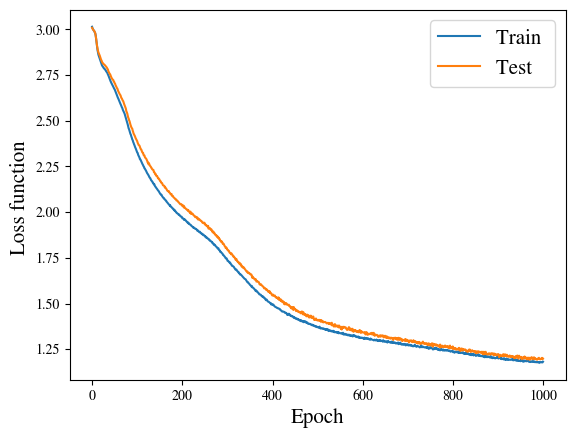

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train ")
plt.plot(test_mse,label="Test ")
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss function ", fontsize = 15)
plt.legend(loc="best", fontsize = 15)
# plt.yscale('log')

In [ ]:
sample =  X_discrete_raw[0:trainsize].to(dtype=torch.long) #  torch.tensor([[14, 30, 42]])
with torch.no_grad():
    # Adjust indexs for embeddings
    f1_idx = sample[:, 0] 
    f2_idx = sample[:, 1] - 1
    stage_idx = sample[:, 2] - 20
    # Get embeddings
    f1_emb = model.var1_emb(f1_idx)
    f2_emb = model.var2_emb(f2_idx)
    st_emb = model.var3_emb(stage_idx)

    # Concatenate embeddings 
    h = torch.cat([f1_emb, f2_emb, st_emb], dim=1)
    h_enc = model.encoder_fc(h)

    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z =  model.reparameterize(mu, logvar)



    y_decoded = model.decoder(z)

    # Spplit logits obtained from decoxder for each variable
    f1_dec, f2_dec, st_dec = torch.chunk(y_decoded, 3 , dim=1)
    f1_logits = model.var1_out(f1_dec)
    f2_logits = model.var2_out(f2_dec) 
    st_logits = model.var3_out(st_dec)


    # Get probabilities using softmax function
    f1_probs = F.softmax(f1_logits, dim=1)
    f2_probs = F.softmax(f2_logits, dim=1)
    st_probs = F.softmax(st_logits, dim=1)

    # Get index with the highest probabilitie and adjust thebase to recvoer true discrete value
    f1_discrete = torch.argmax(f1_probs, dim=1)      
    f2_discrete = torch.argmax(f2_probs, dim=1) + 1  
    st_discrete = torch.argmax(st_probs, dim=1) + 20  

# Combine to get x vector and compare with  initial data used.
discrete_values = torch.cat([f1_discrete.unsqueeze(1), f2_discrete.unsqueeze(1),
                            st_discrete.unsqueeze(1)], dim=1)
discrete_values


tensor([[ 0, 17, 28],
        [ 1, 17, 28],
        [ 2, 17, 58],
        ...,
        [ 3, 21, 38],
        [ 0, 44, 51],
        [ 1, 34, 51]])